In [1]:
import librosa
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib inline

In [2]:
def var_trust_func(Y, numFrames=200):
    x = int(Y.shape[1]/numFrames)
    var_trust = np.ones(Y.shape)
    
    for i in range(0, Y.shape[1], numFrames):
        indice_start = i
        indice_stop = indice_start+numFrames

        Y_p = Y[:,indice_start:indice_stop]
#         var_p = np.sqrt(Y_p.var(1))
        var_p = Y_p.var(1)
        var_p = var_p.reshape(var_p.shape[0],1)   
        var_trust[:,indice_start:indice_stop] = var_p
        
    var_trust = var_trust / np.max(var_trust)
    return(var_trust)

In [3]:
def expand_contrast(contrast_p, shape, n_bands, deltaF):
    contrast = np.ones(shape)
    for i in range(0, n_bands+1):        
        if i == 0:
            indice_start = 0
        else:
            indice_start = deltaF * 2**(i-1)
        
        indice_stop = deltaF * 2**i - 1
        contrast[indice_start:indice_stop,:] = contrast_p[i,:]

    contrast[indice_stop+1:,:] = contrast_p[n_bands,:]    
    return(contrast)

# Retorna a máscara relativa ao contraste
def contrast_trust_func(Y, sr):
    n_bands = 8
    contrast_p = librosa.feature.spectral_contrast(S=Y, sr=sr, linear=True, n_bands=n_bands, fmin=64)
    deltaF = int(round(64/(sr/(2*Y.shape[0]))))
    contrast = expand_contrast(contrast_p, Y.shape, n_bands, deltaF)
    contrast /= np.max(contrast)
    return(contrast)

In [4]:
def my_filter(y, sr):
    Y = librosa.stft(y, n_fft = 4096, hop_length = 512)
    Y_dB = librosa.amplitude_to_db(Y, ref=np.max)
       
    var_trust = var_trust_func(Y_dB)
    contrast = contrast_trust_func(np.abs(Y), sr)
    
    mask = np.multiply(contrast, var_trust)
    mask = mask / np.max(mask)    
    
    mag, phase = librosa.magphase(Y)
    newmag = np.multiply(mag, mask)
    Y_rec = np.multiply(newmag, np.exp(np.multiply(phase, (1j))))
    y_rec = librosa.istft(Y_rec, hop_length=512)

    return y_rec, Y_rec, var_trust, contrast

In [5]:
y, sr = librosa.load("../../audio/trogon10089.mp3", sr=44100)
y = y[:int(len(y)/3)]
Y = librosa.stft(y, n_fft = 4096, hop_length = 512)
Y_dB = librosa.amplitude_to_db(Y, ref=np.max)

In [6]:
IPython.display.Audio(data=y, rate=sr)

In [7]:
ys, Ys, varMask, contrastMask = my_filter(y,sr)

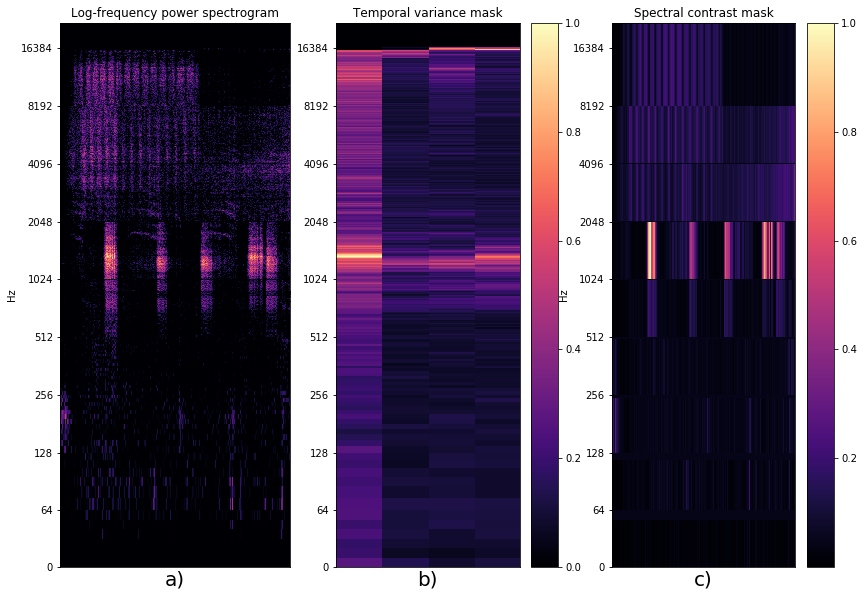

In [13]:
plt.figure(figsize=(14,10))
plt.subplot(1,3,1)
librosa.display.specshow(librosa.amplitude_to_db(Ys, np.max), y_axis='log', sr=sr, hop_length = 512)
# plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')
plt.xlabel("a)", fontsize=20)

plt.subplot(1,3,2)
librosa.display.specshow(varMask, y_axis='log', sr=sr, hop_length = 512)
plt.colorbar()
plt.title('Temporal variance mask')
plt.xlabel("b)", fontsize=20)

plt.subplot(1,3,3)
librosa.display.specshow(contrastMask, y_axis='log', sr=sr, hop_length = 512)
plt.colorbar()
plt.title('Spectral contrast mask')
plt.xlabel("c)", fontsize=20)

In [15]:
Y_recorte = Ys[:,250:450]
variance = np.sqrt(Y_recorte.var(1))
y_axis = np.multiply(list(range(0,Y_recorte.shape[0])),22050/(Y_recorte.shape[0]))    # eixo y em freq, nao bins

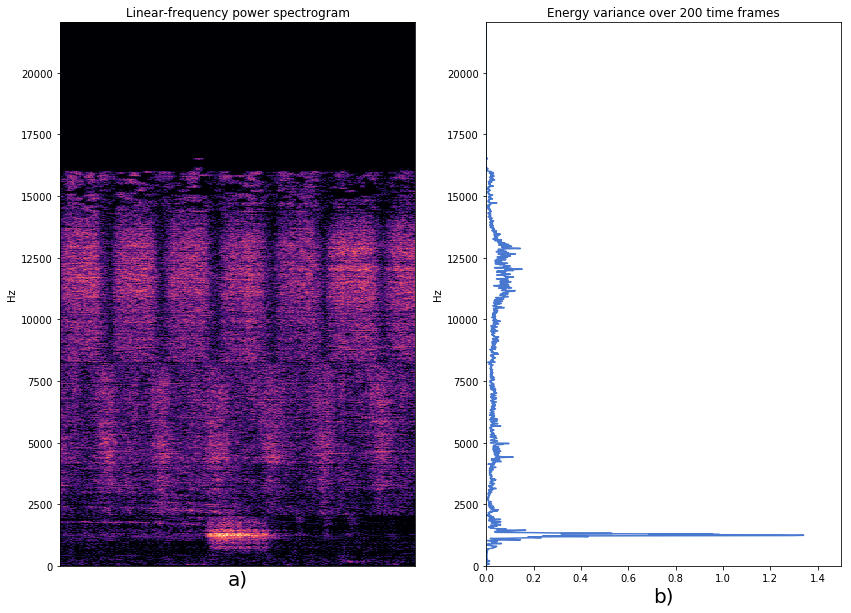

In [16]:
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(Y_recorte, np.max), y_axis='linear', sr=sr, hop_length = 512)
# plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')
plt.xlabel("a)", fontsize=20)


plt.subplot(1,2,2)
plt.plot(variance, y_axis)
plt.axis([0,1.5,0,22050])
plt.xlabel('Standard deviation (dB)')
plt.ylabel('Hz')
plt.title("Energy variance over 200 time frames")
plt.xlabel("b)", fontsize=20)